# Brazil and São Paulo's average income by education level compared.

In this study we compare average income changes between Brazil and its richest city São Paulo. Considering quarterly periods from 2012 to 2020 and difference between education levels.
Data was queried using [(IBGE) Brazilian Institute of Geography and Statistics' API](https://servicodados.ibge.gov.br/api/docs/agregados?versao=3), read using *pandas* and prepared for plotting on and *seaborn*.

### Querying

*What is the average income difference when considering national and regional scale, as well as different education levels for the city of São Paulo?*

In order to provide an answer to that question, IBGE's National Sample Survey of Households (PNAD) - specifically aggregated data code 5935 - was queried considering the following criteria:
- Average income of all citizens, regardless of education level;
- Average income of citizens that completed high school;
- Average income of citizens that have a degree;
- All quarterly periods available.

The following query link was obtained using the [IBGE's query builder](https://servicodados.ibge.gov.br/api/docs/agregados?versao=3#api-bq).

In [8]:
IBGE_query = 'https://servicodados.ibge.gov.br/api/v3/agregados/5438/periodos/201201|201202|201203|201204|201301|201302|201303|201304|201401|201402|201403|201404|201501|201502|201503|201504|201601|201602|201603|201604|201701|201702|201703|201704|201801|201802|201803|201804|201901|201902|201903|201904|202001/variaveis/5935?localidades=N1[all]|N6[3550308]&classificacao=1568[120704,11630,11632]'

In [9]:
import pandas as pd

data = pd.read_json(IBGE_query)
data

,id,variavel,unidade,resultados
0,5935,"Rendimento médio real de todos os trabalhos, e...",Reais,"[{'classificacoes': [{'id': '1568', 'nome': 'N..."


Because the JSON received has its particularities, we are going to use *pandas* to organize data in tabular form.


### Data cleaning

In addition to the time series themselves, the last column of the *'data'* contains education level labels.
This column needs to be expanded, time series extracted and correctly labeled.

In [10]:
# Normalizing json and finding series of interest, gathering useful data labels.
average_income = pd.json_normalize(data.iloc[0,3],
                                   record_path='series',
                                   meta=['classificacoes'])

# Extract category from nested JSON
average_income['categoria']= average_income['classificacoes'].apply(lambda x:list(x['categoria'].values())[0])

# Dropping redundant columns and translating some names
average_income = average_income.drop(columns=['localidade.id', 'localidade.nivel.id',
                                              'localidade.nivel.nome', 'classificacoes'])
average_income.replace({'Ensino médio completo ou equivalente': 'High school',
                        'Ensino superior completo ou equivalente': 'University',
                        'Total': 'All workers',
                        'São Paulo (SP)': 'São Paulo',
                        'Brasil': 'Brazil'},
                       inplace = True)

# Changing columns names
average_income.columns = average_income.columns.str.removeprefix('serie.')
average_income.rename(columns={'categoria': 'Education level',
                               'localidade.nome': 'Location'},
                      inplace=True)
average_income.set_index(['Education level', 'Location'], inplace=True)

# Transposing and setting data type to integer
average_income = average_income.T.astype('int32')
average_income.index.name = 'Quarter'

# Converting integer index to quarterly periods
average_income.index = pd.PeriodIndex(average_income.index.str.replace(r'0(\d)$', r'q\1', regex=True), freq='Q')

# Saving DataFrames separately
average_income.loc[:,(slice(None),'Brazil')].to_csv('PNADcIBGE_Brazil.csv')
average_income.loc[:,(slice(None),'São Paulo')].to_csv('PNADcIBGE_Sao_Paulo.csv')

# We now have data compiled into tabular form
average_income.head()

Education level All workers           High school           University  \
Location             Brazil São Paulo      Brazil São Paulo     Brazil   
Quarter                                                                  
2012Q1                 2729      4009        2452      2716       7081   
2012Q2                 2575      3948        2282      2542       6606   
2012Q3                 2597      3988        2281      2492       6621   
2012Q4                 2617      4139        2289      2590       6602   
2013Q1                 2745      4068        2405      2772       6881   

Education level            
Location        São Paulo  
Quarter                    
2012Q1               8814  
2012Q2               8388  
2012Q3               8498  
2012Q4               8646  
2013Q1               8197

In [11]:
# Some statistics when considering all quarterly periods
average_income.describe().T

count         mean         std     min     25%  \
Education level Location                                                    
All workers     Brazil      33.0  2753.666667  119.002538  2575.0  2686.0   
                São Paulo   33.0  4540.818182  342.289849  3948.0  4406.0   
High school     Brazil      33.0  2270.636364  103.550959  2098.0  2188.0   
                São Paulo   33.0  2582.848485  153.745553  2250.0  2492.0   
University      Brazil      33.0  6563.757576  274.325540  6081.0  6368.0   
                São Paulo   33.0  9254.272727  631.767475  8197.0  8814.0   

                              50%     75%      max  
Education level Location                            
All workers     Brazil     2729.0  2816.0   3044.0  
                São Paulo  4571.0  4731.0   5202.0  
High school     Brazil     2288.0  2348.0   2452.0  
                São Paulo  2590.0  2682.0   2901.0  
University      Brazil     6602.0  6744.0   7081.0  
                São Paulo  9251.0  9596.0  10805.0

### Plotting

*Seaborn* indicates that data in [*long-form*](https://seaborn.pydata.org/tutorial/data_structure.html) is preferable. Thus, transforming our data is required.

In [12]:
average_income_long = average_income.unstack().reset_index()
average_income_long.rename(columns={0:'Average income (BRL)'},
                           inplace=True)

average_income_long.head()

,Education level,Location,Quarter,Average income (BRL)
0,All workers,Brazil,2012Q1,2729
1,All workers,Brazil,2012Q2,2575
2,All workers,Brazil,2012Q3,2597
3,All workers,Brazil,2012Q4,2617
4,All workers,Brazil,2013Q1,2745


In order to compare São Paulo city to Brazil, period data was grouped by education level and plotted in a split violin plot with quartiles.

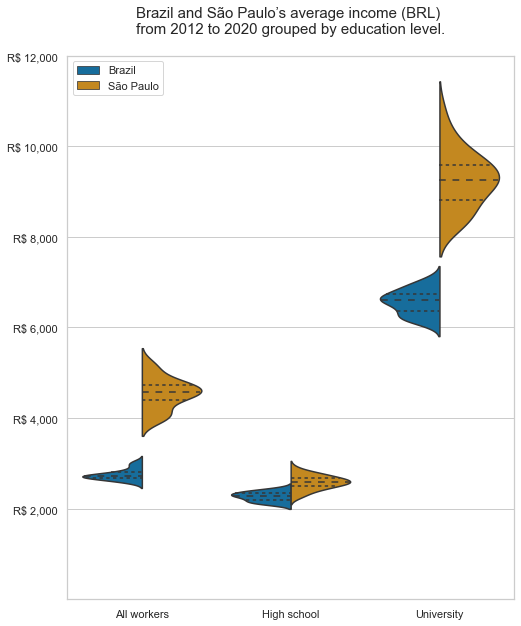

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

sns.set_theme(context='notebook',
              style='whitegrid',
              palette='colorblind')

plt.figure(figsize=(8,10))

ax = sns.violinplot(x='Education level', y='Average income (BRL)', hue='Location',
                    data=average_income_long,
                    split=True,
                    inner='quartile',
                    scale='width')

# Title, legend position and removing labels
ax.set_title('Brazil and São Paulo’s average income (BRL) \n from 2012 to 2020 grouped by education level. \n',
             fontsize=15)
ax.legend(loc='upper left')
ax.set(xlabel=None, ylabel=None)

# Formatting y axis
ax.set_yticks(ax.get_yticks()[1:])
ax.set_ylim(0,12000)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('R$ {x:,.0f}'))

plt.savefig('PNADcIBGE.png')

### Discussion

From 2012 to 2020, São Paulo workers earned consistently and expressively (64%) more than the national average.
The difference diminishes when considering workers that have high school diploma. Still, the regional average was 13% higher.
São Paulo workers that have some university degree earned 41% more than national workers of the same education level.
When comparing the income *'jump'* from high school to university, regional workers with a degree receive 2.58 times more than workers with high school diploma while national workers received 1.89 times more.
The gap between workers with high school diploma and all workers average is also bigger in São Paulo (76% compared to national's 21%), suggesting a higher concentration of higher education workers.